## Quick intro to the homomorphic numpy

Numpy is the fundamental library for operating on arrays in Python. Its central data structure, a multidimensional array called an `ndarray` (for n-dimension array, also known as a tensor), allows programmers to express a variety of scientific computations.

The homomorphic numpy allows us to create a [homomorphic](https://en.wikipedia.org/wiki/Homomorphic_encryption) version of functions operating on `ndarray`s - that is, to operate on encrypted data. Therefore we can receive encrypted data, apply computations on it, send the result back to the user who has the secret key, and the user will be able to get an approximation of applying our function to her data, without ever revealing the contents of her information to us. Therefore the homomorphic numpy ultimately gives us the ability to create programs for private computation, without any previous knowledge of the intricacies of homomorphic encryption.

Let's start with a simple example: imagine that a user wants to know the distance between two points on Earth, but they don't know how to calculate it, nor do they want to reveal these two points; we, on the other hand, know how to compute it, and we want to calculate it for the user. We will start by computing it "in the clear" (that is, over non-encrypted data) and then we'll use the homomorphic numpy to seamlessly transform the function into a homomorphic equivalent.

In [1]:
import numpy as np
import pandas as pd

In [2]:
def distance_on_earth(lat1, lon1, lat2, lon2):
    """ Given arrays of latitudes and longitudes for pairs of points, calculate their distances in km """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

![Alt Text](https://media.giphy.com/media/VI2UC13hwWin1MIfmi/giphy.gif)

First, let's check our function with some randomly generated values. We generate 4 columns (for latitude and longitude of each point) and 10 rows, for 10 pairs of points.

In [3]:
nb_cities = 10
lat_1, lon_1, lat_2, lon_2 = np.random.uniform(-90, 90, size=(4, nb_cities))
distances = distance_on_earth(lat_1, lon_1, lat_2, lon_2)
pd.DataFrame(data=np.vstack((lat_1, lon_1, lat_2, lon_2, distances,)).T, 
             columns=["Latitude 1", "Longitude 1", "Latitude 2", "Longitude 2", "Distances"])

,Latitude 1,Longitude 1,Latitude 2,Longitude 2,Distances
0,25.206744,-14.515073,-31.627559,-58.359903,7844.560996
1,-27.964359,-75.514844,89.619949,35.468337,13123.861267
2,57.454310,14.787825,-32.811268,20.217806,10043.691176
3,27.867751,-41.528989,25.288407,-22.259396,1934.298962
4,67.605039,-50.422756,73.003938,-5.919939,1722.546300
5,-35.249784,-23.955815,81.039086,64.071501,13829.771418
6,-18.264875,9.814222,6.200872,86.075344,8781.800437
7,8.460700,-72.898505,-19.995293,-59.676511,3477.177586
8,-15.855408,-10.724262,-58.707055,30.901453,5848.554013
9,56.276932,5.243858,0.450098,9.536852,6215.742654


Looks good! We now know the 10 distances for those random pairs of points. However, if we were to compute the distances for a user, she would need to reveal the points to us. Let's solve that by making the function homomophic! Let's start by import `hnumpy`:

In [4]:
import hnumpy as hnp

Now, we will call `compile_fhe()`, the function that will translate `distance_on_earth()` into its homomorphic equivalent. In the call to `compile_fhe()`, we will pass to it the name of the function being converted, and the types of the inputs for that function - in our case, each input will be an encrypted array, with a range of values between `-90` and `90`, with a shape of `(10)`

In [5]:
homomorphic_distance_on_earth = hnp.compile_fhe(
    distance_on_earth,
    {
    "lat1": hnp.encrypted_ndarray(bounds=(-90.0, 90.0), shape=(nb_cities,)),
    "lon1": hnp.encrypted_ndarray(bounds=(-90.0, 90.0), shape=(nb_cities,)),
    "lat2": hnp.encrypted_ndarray(bounds=(-90.0, 90.0), shape=(nb_cities,)),
    "lon2": hnp.encrypted_ndarray(bounds=(-90.0, 90.0), shape=(nb_cities,)),
    }
)

2021-10-07 07:52:33.966 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling distance_on_earth into an FHE function
2021-10-07 07:52:33.972 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2021-10-07 07:52:33.979 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2021-10-07 07:52:33.987 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2021-10-07 07:52:34.365 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2021-10-07 07:52:34.370 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2021-10-07 07:52:34.384 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller


The `compile_fhe` takes a function as input and outputs a homomorphic equivalent of it. 

Now, we need to generate keys (private and public) for our FHE model. Remark that, depending on the FHE model, it may be more or less long.

In [6]:
context = homomorphic_distance_on_earth.create_context()
keys = context.keygen()

2021-10-07 07:52:34.411 | INFO     | hnumpy.client:keygen:28 - Creating 1 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 40 seconds (0.6666666666666666 minutes)
2021-10-07 08:11:42.803 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 1148.3381107710002 seconds


From now on, we can just call `encrypt_and_run`, allowing us to make the same computations on encrypted data, without ever having access to the underlying information. The output of the function will also be encrypted, and whoever has the corresponding secret key can decrypt it.

Now, let's start the FHE experience. On her device, with her private key, the user can encrypt data, with her private key

In [7]:
encrypted_lat_1, encrypted_lon_1, encrypted_lat_2, encrypted_lon_2 = keys.encrypt(lat_1, lon_1, lat_2, lon_2)

Now, the user can (safely) send her encrypted data to the server, which can run the compiled FHE network, with only public keys

In [8]:
encrypted_result = homomorphic_distance_on_earth.run(keys.public_keys, 
                                                     encrypted_lat_1, encrypted_lon_1, 
                                                     encrypted_lat_2, encrypted_lon_2)

Finally, the encrypted result is returned to the user, who can use her private key to decrypt the content. Her private data has never left her device, her privacy was ensured end-to-end

In [9]:
h_distances = keys.decrypt(encrypted_result)

Remark that, here, we've used three API (`encrypt`, `run` and `decrypt`) to be clear on how FHE protects your data. For simplicity of tests, we propose a combined `encrypt_and_run` all-in-one call, who's examplified later in this notebook.

Now let's check on a table the results originally computed and the results computed homomorphically

In [10]:
error = np.abs(h_distances - distances)
pd.DataFrame(data=np.vstack((lat_1, lon_1, lat_2, lon_2, distances, h_distances, error)).T, 
             columns=["Latitude 1", "Longitude 1", "Latitude 2", "Longitude 2", "Distances", 
                      "Homomorphic Distances", "Homomorphic Error"])

,Latitude 1,Longitude 1,Latitude 2,Longitude 2,Distances,Homomorphic Distances,Homomorphic Error
0,25.206744,-14.515073,-31.627559,-58.359903,7844.560996,7670.621086,173.939910
1,-27.964359,-75.514844,89.619949,35.468337,13123.861267,13028.405314,95.455953
2,57.454310,14.787825,-32.811268,20.217806,10043.691176,10028.809983,14.881193
3,27.867751,-41.528989,25.288407,-22.259396,1934.298962,2729.711248,795.412286
4,67.605039,-50.422756,73.003938,-5.919939,1722.546300,1786.052250,63.505950
5,-35.249784,-23.955815,81.039086,64.071501,13829.771418,13790.071022,39.700396
6,-18.264875,9.814222,6.200872,86.075344,8781.800437,8740.864024,40.936413
7,8.460700,-72.898505,-19.995293,-59.676511,3477.177586,3404.515847,72.661739
8,-15.855408,-10.724262,-58.707055,30.901453,5848.554013,6153.016371,304.462359
9,56.276932,5.243858,0.450098,9.536852,6215.742654,6260.893912,45.151258


We can notice that the error when computing the function homomorphically can get quite large, and the computation itself is much slower. The main challenges with running homomorphic programs is that the computations are much more expensive than the equivalent ones on non-encrypted data, and, additionally, they have very limited precision. As a result, we see both a slowdown and a loss of precision.

The homomorphic numpy comes with some tools to allow us to inspect our homomorphic function more closely, in case we want to explore how to improve its performance and precision. By calling `expected_precision()`, we can check what is the theoretical precision we should have, and compare to what is achieve in practice.

In [11]:
print(f"Expected precision: ±{homomorphic_distance_on_earth.expected_precision()}")
print(f"Mean and standard deviation of the error: {np.mean(error)}, {np.std(error)}")

Expected precision: ±[1236.37914666549]
Mean and standard deviation of the error: 164.61074578941998, 225.52222041281476


We can also check the computational graphs of our cleartext function:

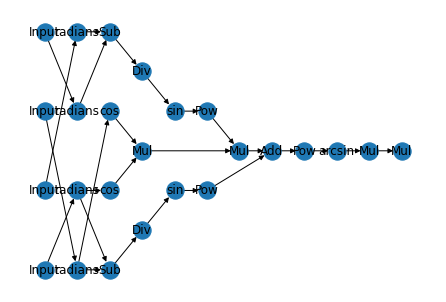

In [12]:
homomorphic_distance_on_earth.draw_intermediate_graph()

...and of the homomorphic equivalent:

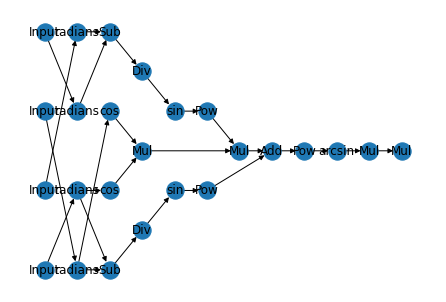

In [13]:
homomorphic_distance_on_earth.draw_intermediate_graph()

### Getting better precision

One strategy to get better precision is to restrict our bounds. For instance, if we just want to calculate distances within Europe, we could restrict our bounds to its maximum and minimum latitude and longitude. 

In [14]:
min_lat, max_lat = 36, 71
min_lon, max_lon = -28, 69
nb_cities = 20

In [15]:
homomorphic_distance_on_earth = hnp.compile_fhe(
    distance_on_earth,
    {
    "lat1": hnp.encrypted_ndarray(bounds=(min_lat, max_lat), shape=(nb_cities,)),
    "lon1": hnp.encrypted_ndarray(bounds=(min_lon, max_lon), shape=(nb_cities,)),
    "lat2": hnp.encrypted_ndarray(bounds=(min_lat, max_lat), shape=(nb_cities,)),
    "lon2": hnp.encrypted_ndarray(bounds=(min_lon, max_lon), shape=(nb_cities,)),
    }       
)

2021-10-07 08:18:47.632 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling distance_on_earth into an FHE function
2021-10-07 08:18:47.638 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2021-10-07 08:18:47.646 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2021-10-07 08:18:47.658 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2021-10-07 08:18:48.019 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2021-10-07 08:18:48.023 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2021-10-07 08:18:48.032 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller


In [16]:
context = homomorphic_distance_on_earth.create_context()
keys = context.keygen()

2021-10-07 08:18:48.055 | INFO     | hnumpy.client:keygen:28 - Creating 1 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 40 seconds (0.6666666666666666 minutes)
2021-10-07 08:37:57.974 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 1149.8959846040002 seconds


Now, let's pick some pairs of cities in Europe to measure their distance homomorphically

In [17]:
lat_1, lat_2 = np.random.uniform(min_lat, max_lat, size=(2, nb_cities))
lon_1, lon_2 = np.random.uniform(min_lon, max_lon, size=(2, nb_cities))
distances = distance_on_earth(lat_1, lon_1, lat_2, lon_2)
pd.DataFrame(data=np.vstack((lat_1, lon_1, lat_2, lon_2, distances,)).T, 
             columns=["Latitude 1", "Longitude 1", "Latitude 2", "Longitude 2", "Distances"])


,Latitude 1,Longitude 1,Latitude 2,Longitude 2,Distances
0,58.025332,29.590934,63.110099,-0.870315,1737.234035
1,57.108802,-18.995845,63.750886,-9.778054,892.720698
2,63.055196,-14.585061,64.507856,56.039384,3291.084879
3,67.971868,-13.686694,68.923800,11.092889,1010.040031
4,70.597399,-5.652870,40.511178,65.478902,5114.193735
5,65.748132,11.588224,36.058985,58.034903,4450.727749
6,44.368791,21.600003,48.436459,58.701326,2850.073639
7,41.625529,-27.663936,51.094636,49.084105,5706.515159
8,47.021714,50.664306,66.644089,55.541676,2199.017906
9,50.087743,0.469952,70.965630,8.136365,2353.247143


For comparison, we'll compute in the clear and homomorphically. Remark that now, we use combined API `encrypt_and_run`, for the sake of simplify.

In [18]:
distances = distance_on_earth(lat_1, lon_1, lat_2, lon_2)
h_distances = homomorphic_distance_on_earth.encrypt_and_run(keys, lat_1, lon_1, lat_2, lon_2)

And, finally, we visualize the results

In [19]:
error = np.abs(h_distances - distances)
pd.DataFrame(data=np.vstack((lat_1, lon_1, lat_2, lon_2, distances, h_distances, error)).T, 
             columns=["Latitude 1", "Longitude 1", "Latitude 2", "Longitude 2", "Distances", 
                      "Homomorphic Distances", "Homomorphic Error"])

,Latitude 1,Longitude 1,Latitude 2,Longitude 2,Distances,Homomorphic Distances,Homomorphic Error
0,58.025332,29.590934,63.110099,-0.870315,1737.234035,1614.066042,123.167992
1,57.108802,-18.995845,63.750886,-9.778054,892.720698,894.176867,1.456169
2,63.055196,-14.585061,64.507856,56.039384,3291.084879,3323.089978,32.005099
3,67.971868,-13.686694,68.923800,11.092889,1010.040031,918.982277,91.057754
4,70.597399,-5.652870,40.511178,65.478902,5114.193735,5119.264270,5.070535
5,65.748132,11.588224,36.058985,58.034903,4450.727749,0.000272,4450.727477
6,44.368791,21.600003,48.436459,58.701326,2850.073639,2696.593276,153.480362
7,41.625529,-27.663936,51.094636,49.084105,5706.515159,5918.713699,212.198541
8,47.021714,50.664306,66.644089,55.541676,2199.017906,2240.232464,41.214558
9,50.087743,0.469952,70.965630,8.136365,2353.247143,1886.425018,466.822125


We can check that if the results are within the expected error:

In [20]:
print(f"Expected precision: ±{homomorphic_distance_on_earth.expected_precision()}")
print(f"Mean and standard deviation of the error: {np.mean(error)}, {np.std(error)}")

Expected precision: ±[593.221705254558]
Mean and standard deviation of the error: 329.11026621437225, 951.08991158048
